# Mel Spectrogram Inversion with PyTorch and nnAudio

In [1]:
%load_ext autoreload
%autoreload 2

## Import Dependencies

In [307]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Audio

import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
from nnAudio import Spectrogram

from beatbrain.datasets.audio import AudioClipDataset

## Define Constants

In [408]:
AUDIO_PATH = "../data/edm/wav"
SR = 22050
N_FFT = 2048
HOP_LENGTH = N_FFT // 8
N_MELS = 256
DEVICE = "cuda"
eps = 1e-12

def draw_log_spectrogram(S):
    plt.imshow(S, origin="lower", norm=matplotlib.colors.LogNorm())
    plt.colorbar()

In [409]:
def power_to_db(spec, ref=1.0, amin=1e-10, top_db=80.0):
    if amin <= 0:
        raise ValueError('amin must be strictly positive')
    if callable(ref):
        ref_value = ref(magnitude)
    else:
        ref_value = np.abs(ref)

    amin = torch.tensor(amin, dtype=torch.float32, device=spec.device)
    ref_value = torch.tensor(ref_value, dtype=torch.float32, device=spec.device)

    log_spec = 10.0 * torch.log10(torch.max(amin, spec))
    log_spec -= 10.0 * torch.log10(torch.max(amin, ref_value))

    if top_db is not None:
        if top_db < 0:
            raise ValueError('top_db must be non-negative')
        log_spec = torch.max(log_spec, log_spec.max() - top_db)

    return log_spec

def db_to_power(spec_db, ref=1.0):
    return ref * torch.pow(10.0, 0.1 * spec_db)

## Load Audio Sample

In [410]:
dataset = AudioClipDataset(AUDIO_PATH, sample_rate=SR)
audio, sr = dataset[5000]
audio_tensor = torch.tensor(audio, dtype=torch.float32, device=DEVICE)
display(Audio(audio, rate=sr))

## Compute STFT and Mel Spectrograms

### Create Mel Filterbank

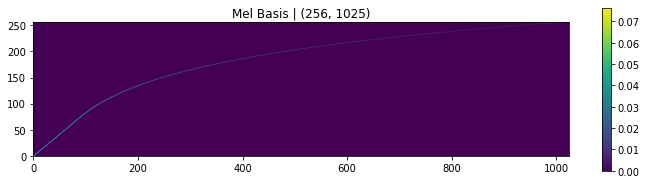

In [411]:
mel_basis = librosa.filters.mel(SR, N_FFT, n_mels=N_MELS)
mel_basis_tensor = torch.tensor(mel_basis, device=DEVICE).unsqueeze(0)
plt.figure(figsize=(12, 3))
plt.imshow(mel_basis, origin='lower')
plt.colorbar()
plt.title(f"Mel Basis | {mel_basis.shape}")
plt.show()

### Create nnAudio Modules

In [412]:
to_stft = Spectrogram.STFT(N_FFT, hop_length=HOP_LENGTH, sr=SR, output_format="Magnitude", device=DEVICE)
to_mel = Spectrogram.MelSpectrogram(n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, sr=SR, device=DEVICE)

STFT kernels created, time used = 0.2216 seconds
STFT filter created, time used = 0.0050 seconds
Mel filter created, time used = 0.0050 seconds


### STFT Spectrograms

#### nnAudio

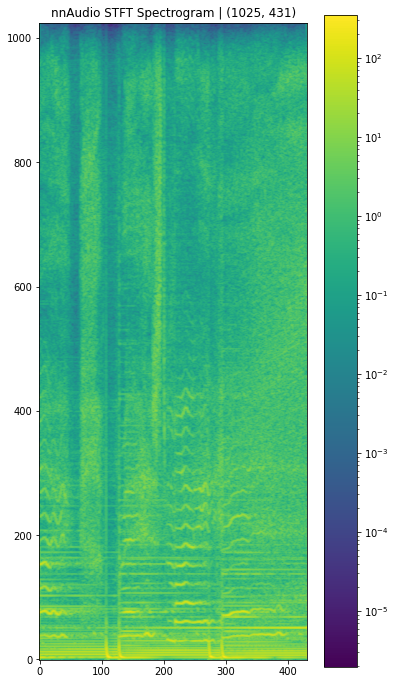

In [413]:
nnaudio_stft = to_stft(audio_tensor)
plt.figure(figsize=(6, 12))
draw_log_spectrogram(nnaudio_stft[0].cpu())
plt.title(f"nnAudio STFT Spectrogram | {tuple(nnaudio_stft[0].shape)}")
plt.show()

#### librosa

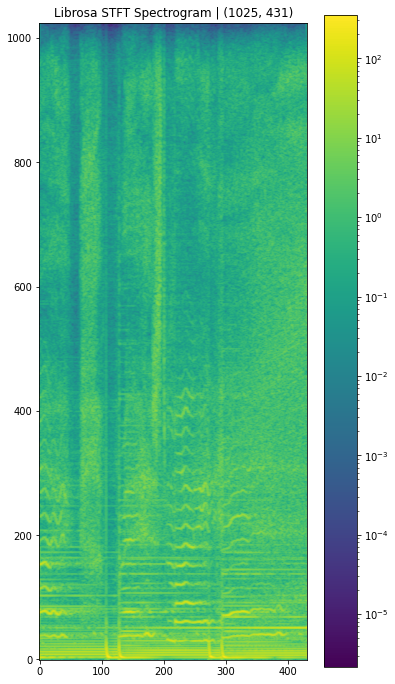

In [414]:
librosa_stft = np.abs(librosa.stft(audio[0], n_fft=N_FFT, hop_length=HOP_LENGTH))
plt.figure(figsize=(6, 12))
draw_log_spectrogram(librosa_stft)
plt.title(f"Librosa STFT Spectrogram | {librosa_stft.shape}")
plt.show()

### Mel Spectrograms

#### nnAudio Direct

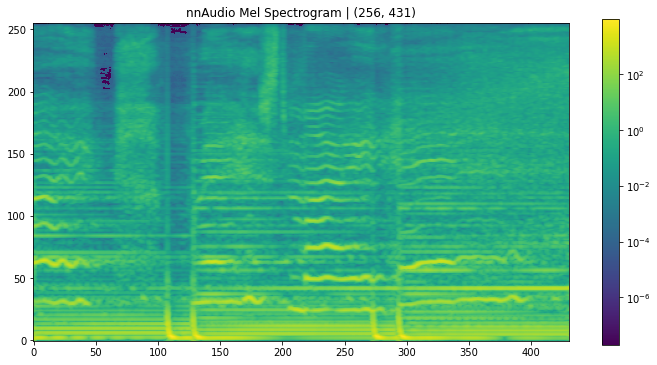

In [415]:
nnaudio_mel = to_mel(audio_tensor)
plt.figure(figsize=(12, 6))
draw_log_spectrogram(nnaudio_mel[0].cpu())
plt.title(f"nnAudio Mel Spectrogram | {tuple(nnaudio_mel[0].shape)}")
plt.show()

#### nnAudio STFT -> Mel

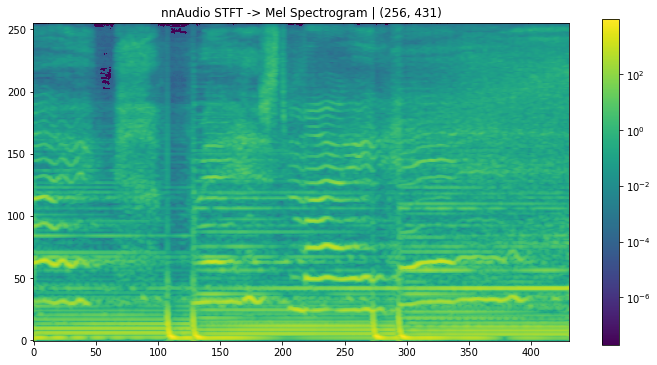

In [416]:
nnaudio_stft_mel = mel_basis_tensor @ (nnaudio_stft ** 2)
plt.figure(figsize=(12, 6))
draw_log_spectrogram(nnaudio_stft_mel[0].cpu())
plt.title(f"nnAudio STFT -> Mel Spectrogram | {tuple(nnaudio_stft_mel[0].shape)}")
plt.show()

#### librosa Direct

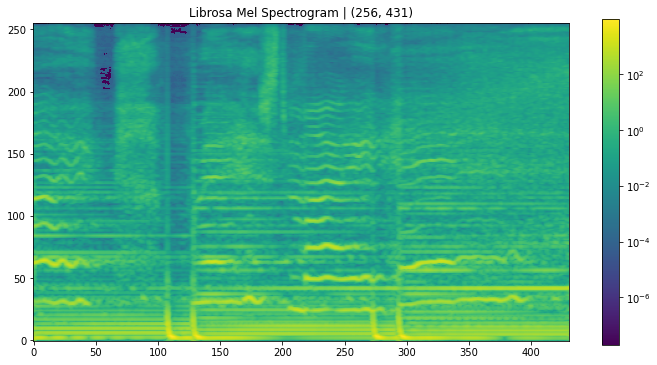

In [417]:
librosa_mel = librosa.feature.melspectrogram(audio[0], n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, sr=SR)
plt.figure(figsize=(12, 6))
draw_log_spectrogram(librosa_mel)
plt.title(f"Librosa Mel Spectrogram | {librosa_mel.shape}")
plt.show()

#### librosa STFT -> Mel

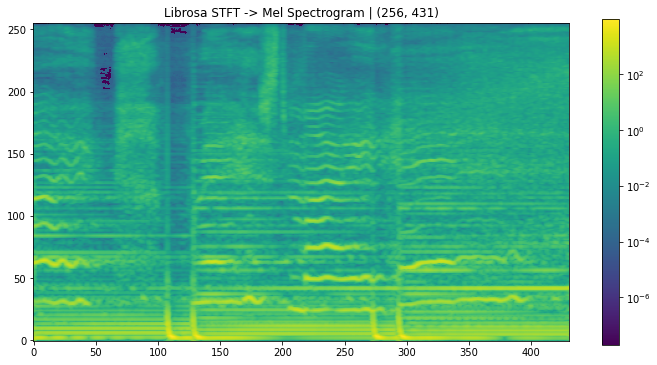

In [418]:
librosa_stft_mel = mel_basis.dot(librosa_stft ** 2)
plt.figure(figsize=(12, 6))
draw_log_spectrogram(librosa_stft_mel)
plt.title(f"Librosa STFT -> Mel Spectrogram | {librosa_stft_mel.shape}")
plt.show()

### Comparing Mel Spectrogram methods

In [419]:
nnaudio_mel_diff = (nnaudio_mel - nnaudio_stft_mel).abs()
print(f"nnAudio Direct VS nnAudio STFT -> Mel methods: {100 * nnaudio_mel_diff.sum() / nnaudio_mel.sum():.10f}%")

librosa_mel_diff = np.abs(librosa_mel - librosa_stft_mel)
print(f"librosa Direct VS librosa STFT -> Mel methods: {100 * librosa_mel_diff.sum() / librosa_mel.sum():.10f}%")

librosa_nnaudio_mel_diff = np.abs(librosa_mel - nnaudio_mel.cpu().detach().numpy())
print(f"librosa Direct VS nnAudio Direct methods: {100 * librosa_nnaudio_mel_diff.sum() / librosa_mel.sum():.10f}%")

nnAudio Direct VS nnAudio STFT -> Mel methods: 0.0000000000%
librosa Direct VS librosa STFT -> Mel methods: 0.0000000000%
librosa Direct VS nnAudio Direct methods: 0.0000820442%


## Reconstruct STFT & Audio from Mel Spectrogram

### librosa Direct

In [375]:
%%time
librosa_recon_stft = librosa.feature.inverse.mel_to_stft(nnaudio_mel[0].cpu().numpy(), sr=SR, n_fft=N_FFT)

Librosa Mel -> STFT Error: 216506.203125


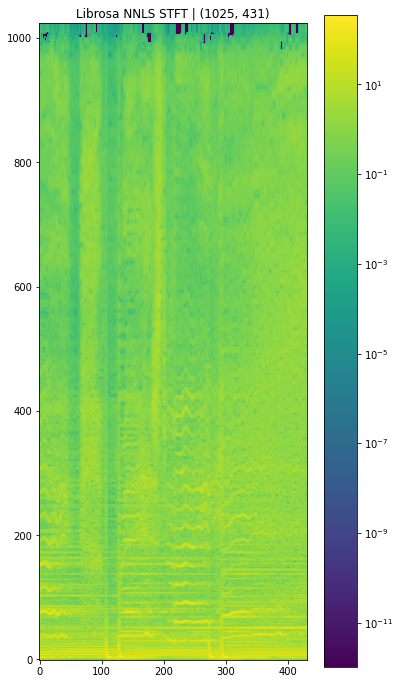

In [385]:
librosa_err = ((librosa_recon_stft - nnaudio_stft.cpu().numpy()) ** 2).sum()
print(f"Librosa Mel -> STFT Error: {librosa_err.item()}")

plt.figure(figsize=(6, 12))
draw_log_spectrogram(librosa_recon_stft.clip(eps))
plt.title(f"Librosa NNLS STFT | {librosa_recon_stft.shape}")
plt.show()

In [383]:
librosa_recon_audio = librosa.griffinlim(librosa_recon_stft, hop_length=HOP_LENGTH)
display(Audio(librosa_recon_audio, rate=SR))

### PyTorch Optimization

LR: 1000000.0
Target error of 1e-09 reached. Stopping optimization.
Final loss: 9.675e-10
nnAudio STFT Reconstruction MSE: 8.884e+05
nnAudio STFT Reconstruction PSNR: 47.849
nnAudio Mel Reconstruction PSNR: 170.105


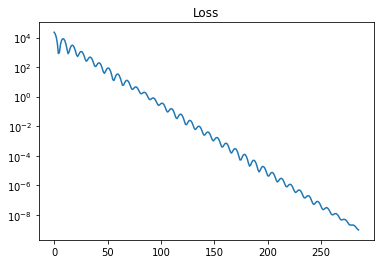

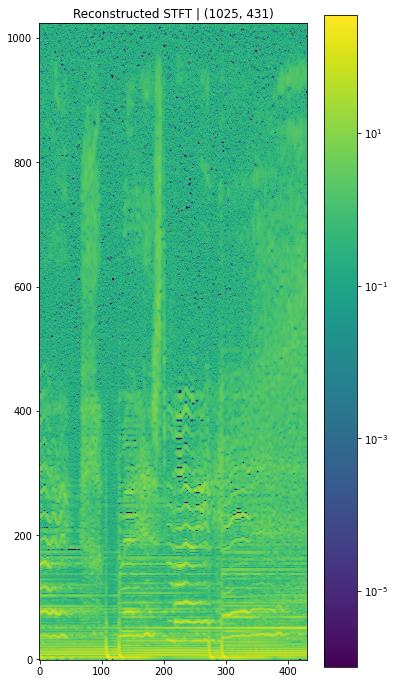

Wall time: 2.23 s


In [420]:
%%time
def psnr(pred, target, target_top=True, top=1e4):
    if target_top:
        top = target.max()
    return 20 * torch.log10(top / torch.sqrt(F.mse_loss(pred, target)))

def stft_loss(pred, target, scales=3, eps=1e-12):
    pred = pred.unsqueeze(1) if pred.ndim == 3 else pred
    target = target.unsqueeze(1) if target.ndim == 3 else target

    loss = torch.tensor(0, dtype=torch.float32, device=pred.device)
    scale_values = [2 ** scale for scale in range(scales)]
    for scale in scale_values:
        if scale > 1:
            pred_scaled = F.interpolate(pred, scale_factor=1 / scale, mode="bilinear", align_corners=True)
            target_scaled = F.interpolate(target, scale_factor=1 / scale, mode="bilinear", align_corners=True)
        else:
            pred_scaled, target_scaled = pred, target
        scale_loss = F.mse_loss(pred, target, reduction="none")
        loss += scale_loss.mean() * scale

    return loss / scales


lr = 1e6
max_steps = 1000
err_threshold = 1e-9
psnr_threshold = 180
min_grad = 1e-12

print(f"LR: {lr}")
nnaudio_recon_stft_shape = (nnaudio_mel.shape[0], mel_basis_tensor.shape[-1], nnaudio_mel.shape[-1])
nnaudio_recon_stft = torch.zeros(*nnaudio_recon_stft_shape, dtype=torch.float32, device=DEVICE).normal_().clamp_(0, None)
nnaudio_recon_stft = nn.Parameter(nnaudio_recon_stft, requires_grad=True)
optimizer = torch.optim.SGD([nnaudio_recon_stft], lr=lr, momentum=0.9, nesterov=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=100, threshold=1e-6, min_lr=1e-5, verbose=True, mode="min")

losses = []
for i in range(max_steps):
    optimizer.zero_grad()
    pred_mel = mel_basis_tensor @ nnaudio_recon_stft
    loss = stft_loss(pred_mel, nnaudio_mel, scales=1)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    # Check conditions
    if psnr(pred_mel, nnaudio_mel) >= psnr_threshold:
        print(f"Target PSNR of {psnr_threshold} reached. Stopping optimization.")
        break
    if loss <= err_threshold:
        print(f"Target error of {err_threshold} reached. Stopping optimization.")
        break
    if nnaudio_recon_stft.grad.abs().max() <= min_grad:
        print(f"Target grad of {min_grad} reached. Stopping optimization.")
        break
nnaudio_recon_stft = nnaudio_recon_stft.detach().clamp(eps, None) ** 0.5

print(f"Final loss: {losses[-1]:.3e}")
nnaudio_err = F.mse_loss(nnaudio_recon_stft, nnaudio_stft, reduction="sum")
print(f"nnAudio STFT Reconstruction MSE: {nnaudio_err.item():.3e}")
nnaudio_stft_psnr = psnr(nnaudio_recon_stft, nnaudio_stft)
print(f"nnAudio STFT Reconstruction PSNR: {nnaudio_stft_psnr.item():.3f}")
nnaudio_mel_psnr = psnr(pred_mel, nnaudio_mel)
print(f"nnAudio Mel Reconstruction PSNR: {nnaudio_mel_psnr.item():.3f}")

plt.plot(losses)
plt.yscale("log")
plt.title(f"Loss")
plt.show()

plt.figure(figsize=(6, 12))
draw_log_spectrogram(nnaudio_recon_stft[0].cpu().detach())
plt.title(f"Reconstructed STFT | {tuple(nnaudio_recon_stft[0].shape)}")
plt.show()

nnaudio_recon_audio = librosa.griffinlim(nnaudio_recon_stft[0].cpu().detach().numpy(), hop_length=HOP_LENGTH)
display(Audio(nnaudio_recon_audio, rate=SR))

### Visualize Reconstruction Error

Reconstructed STFT MSE: 1.522e+06


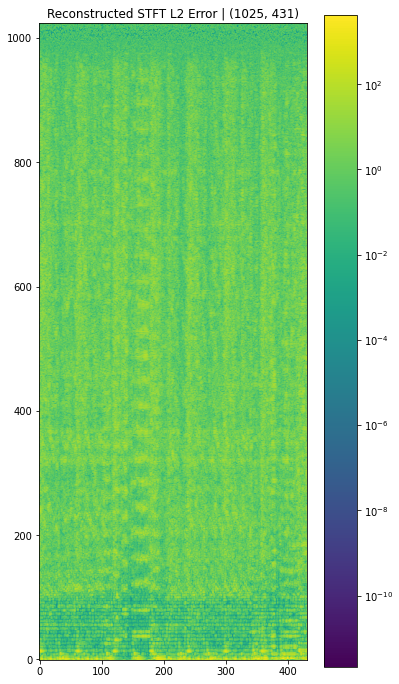

Predicted Mel MSE: 6.399e-06


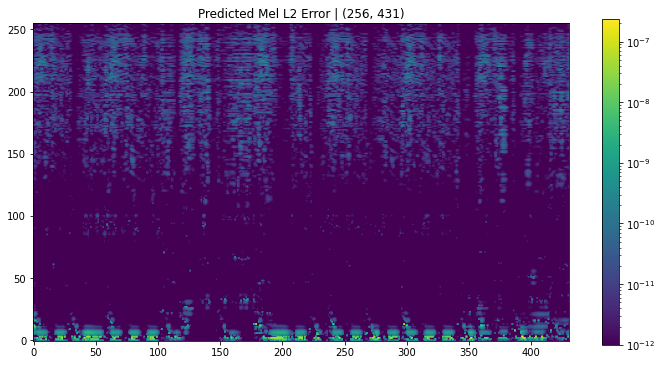

In [328]:
stft_err_l2 = F.mse_loss(nnaudio_recon_stft, nnaudio_stft, reduction="none").clamp(eps, None)
print(f"Reconstructed STFT MSE: {stft_err_l2.sum():.3e}")
plt.figure(figsize=(6, 12))
draw_log_spectrogram(stft_err_l2[0].cpu().detach())
plt.title(f"Reconstructed STFT L2 Error | {tuple(stft_err_l2[0].shape)}")
plt.show()

mel_err_l2 = F.mse_loss(pred_mel, nnaudio_mel, reduction="none").clamp(eps, None)
print(f"Predicted Mel MSE: {mel_err_l2.sum():.3e}")
plt.figure(figsize=(12, 6))
draw_log_spectrogram(mel_err_l2[0].cpu().detach(),)
plt.title(f"Predicted Mel L2 Error | {tuple(mel_err_l2[0].shape)}")
plt.show()

In [ ]:
class InvertibleMelSpectrogram(Spectrogram.MelSpectrogram):
    # TODO: Copy params and forward pass from MelGan
    def __init__(self, *args, **kwargs):
        pass
    def forward(self, audio):
        """
        Audio to mel spectrogram
        """
        pass
    def inverse(self, spec):
        """
        Best-attempt spectrogram inversion
        """
        pass